# 2023 Cricket World Cup EDA

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid")
os.makedirs("images", exist_ok=True)

In [53]:
df = pd.read_csv("CWC2023.csv")
df.columns = [c.strip() for c in df.columns]
df.head()

,Match ID,Match Date,Match Time,City,Stadium,Team A,Team B,Toss Winner,Toss Decision,Score A,...,No Balls B,Penalty B,Extras B,Wining Team,Margin,Man of the Match,Umpire 1,Umpire 2,TV Umpire,Match Refree
0,1,05-10-2023,2:00 PM,Ahmedabad,Narendra Modi Stadium,England,NewZealand,NewZealand,Field,282,...,0,0,6,NewZealand,9 Wickets,Rachin Ravindra,Kumar Dharmasena,Nitin Menon,Paul Wilson,Javagal Srinath
1,2,06-10-2023,2:00 PM,Hyderabad,Eden Gardens,Pakistan,Netherlands,Netherlands,Field,286,...,1,0,9,Pakistan,81 Runs,Saud Shakeel,Adrian Holdstock,Chris Brown,Rod Tucker,Jeff Crowe
2,3,07-10-2023,2:00 PM,Dharamshala,HPCA Stadium,Afghanistan,Bangladesh,Bangladesh,Field,156,...,0,0,8,Bangladesh,6 Wickets,Mehidy Hasan Miraz,Joel Wilson,Kumar Dharmasena,Ahsan Raza,Andy Pycroft
3,4,07-10-2023,2:00 PM,Delhi,Arun Jaitley Stadium,South Africa,Sri Lanka,Sri Lanka,Field,428,...,1,0,23,South Africa,102 Runs,Aiden Markram,Richard Illingworth,Sharfuddoula,Michael Gough,Javagal Srinath
4,5,08-10-2023,2:00 PM,Chennai,M. A. Chidambaram Stadium,Australia,India,Australia,Bat,199,...,0,0,12,India,6 wickets,KL Rahul,Chris Gaffaney,Richard Kettleborough,Chris Brown,Richie Richardson


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Match ID          48 non-null     int64  
 1   Match Date        48 non-null     object 
 2   Match Time        48 non-null     object 
 3   City              48 non-null     object 
 4   Stadium           48 non-null     object 
 5   Team A            48 non-null     object 
 6   Team B            48 non-null     object 
 7   Toss Winner       48 non-null     object 
 8   Toss Decision     48 non-null     object 
 9   Score A           48 non-null     int64  
 10  Wickets A         48 non-null     int64  
 11  Overs Played A    48 non-null     float64
 12  Maiden Overs A    48 non-null     int64  
 13  4s A              48 non-null     int64  
 14  6s A              48 non-null     int64  
 15  Boundaries A      48 non-null     int64  
 16  Runrate A         48 non-null     float64
 17 

In [33]:
def str_to_float(series):
    return (
        series.astype(str)
        .str.replace('-', '0')
        .str.replace(',', '.', regex=False)
        .str.replace(' ', '')
        .replace(['', 'nan', 'None'], '0')
        .astype(float)
    )

for col in ['Runrate A', 'Runrate B', 'Overs Played A', 'Overs Played B']:
    if col in df.columns:
        df[col] = str_to_float(df[col])

df['Match Date'] = pd.to_datetime(df['Match Date'], dayfirst=True, errors='coerce')
for col in ['Team A','Team B','Wining Team','Toss Decision','Toss Winner']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if 'Margin' in df.columns:
    def win_type(m):
        m = str(m)
        if 'wicket' in m.lower():
            return 'Wickets'
        if 'run' in m.lower():
            return 'Runs'
        return 'Other'
    df['Win Type'] = df['Margin'].apply(win_type)

# Build dataset for scores
rows_a = df[['Team A','Score A']].rename(columns={'Team A':'Team','Score A':'Runs'})
rows_b = df[['Team B','Score B']].rename(columns={'Team B':'Team','Score B':'Runs'})
all_scores = pd.concat([rows_a, rows_b])
team_runs = all_scores.groupby('Team')['Runs'].agg(['sum','mean','median']).sort_values('sum', ascending=False)


## 1. Average Runs Per Team

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/1006621543.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=team_runs.index, y=team_runs['mean'], order=order, palette='deep')


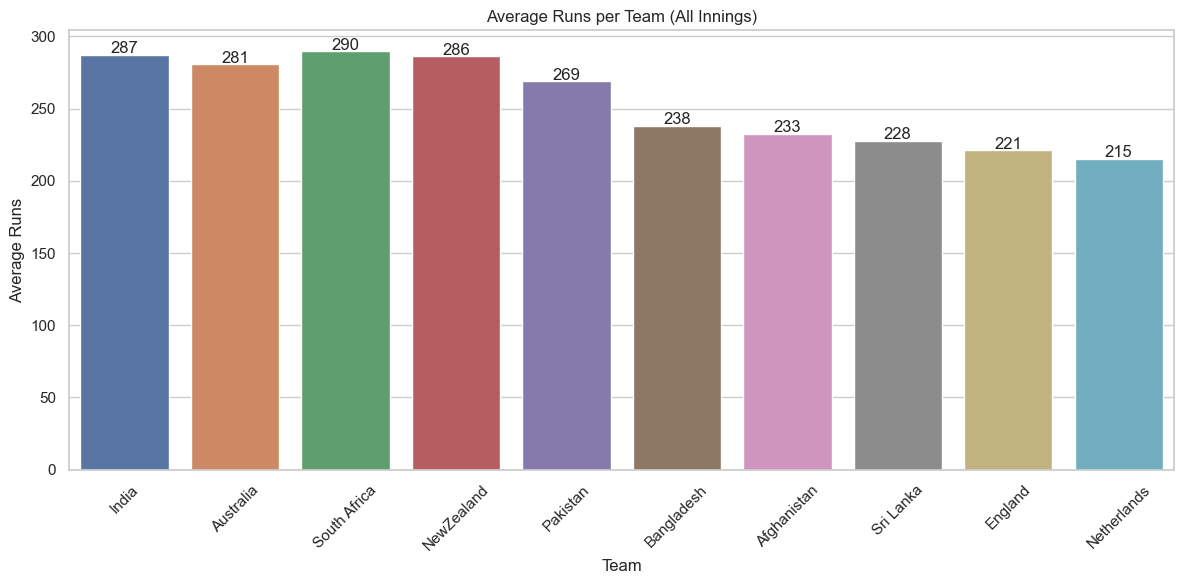

In [34]:
plt.figure(figsize=(12,6))
order = team_runs.index.tolist()
sns.barplot(x=team_runs.index, y=team_runs['mean'], order=order, palette='deep')
plt.xticks(rotation=45)
plt.ylabel('Average Runs')
plt.title('Average Runs per Team (All Innings)')
for i, v in enumerate(team_runs['mean']):
    plt.text(i, v+1, f"{v:.0f}", ha='center')
plt.tight_layout()
plt.savefig('images/01_avg_runs_per_team.png', dpi=150)
plt.show()


### 📊 Insight: India consistently sits at the top in mean runs → batting lineup delivers across matches.

## 2. Runs Distribution

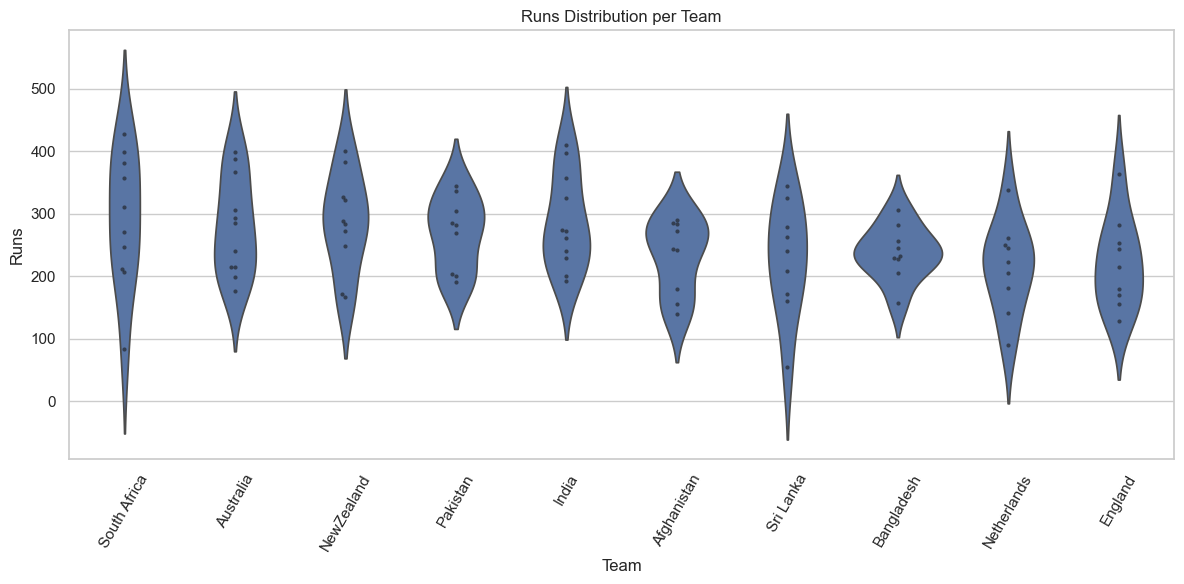

In [36]:
plt.figure(figsize=(12,6))
order = all_scores.groupby('Team')['Runs'].median().sort_values(ascending=False).index
sns.violinplot(x='Team', y='Runs', data=all_scores, order=order, inner=None)
sns.swarmplot(x='Team', y='Runs', data=all_scores, order=order, size=3, color='k', alpha=0.6)
plt.xticks(rotation=60)
plt.title('Runs Distribution per Team')
plt.tight_layout()
plt.savefig('images/02_score_distribution.png', dpi=150)
plt.show()


### 📊 Insight: India & SA show fat tails → big scores possible, pressure games tilt in their favor.

## 3. Total Runs per Team

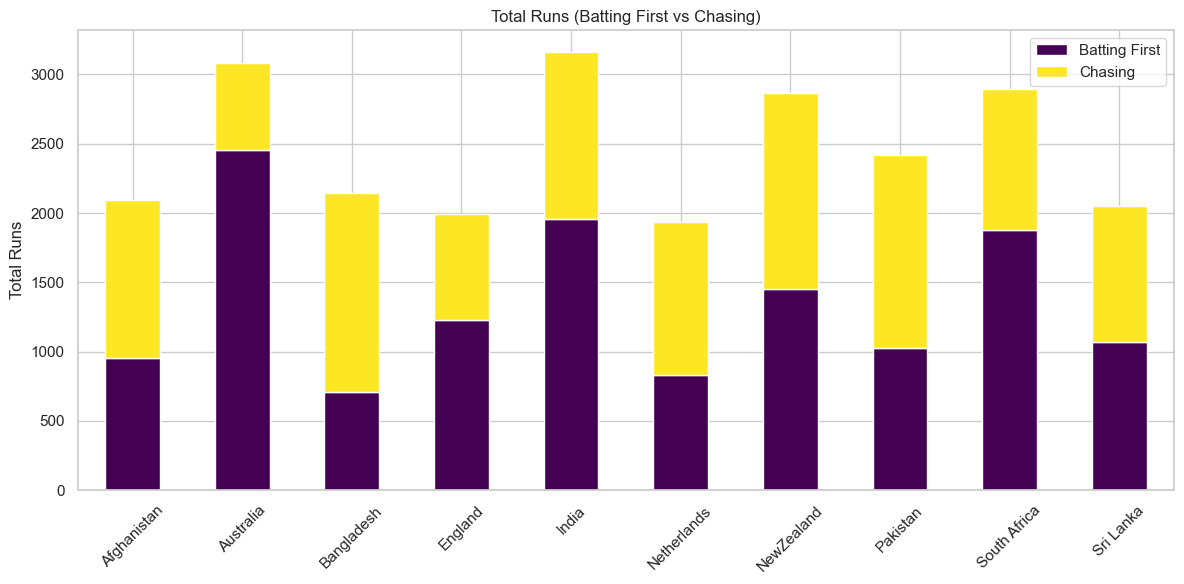

In [37]:
team_totals = pd.DataFrame({
    'Batting First': df.groupby('Team A')['Score A'].sum(),
    'Chasing': df.groupby('Team B')['Score B'].sum()
}).fillna(0)

team_totals.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.ylabel("Total Runs")
plt.title("Total Runs (Batting First vs Chasing)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/03_total_runs_stacked.png", dpi=150)
plt.show()


### 📊 Insight: India dominates in both modes — versatile whether setting or chasing.

## 4. Toss Decision Impact

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/3579369390.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Toss Decision', data=df, palette='Set2')


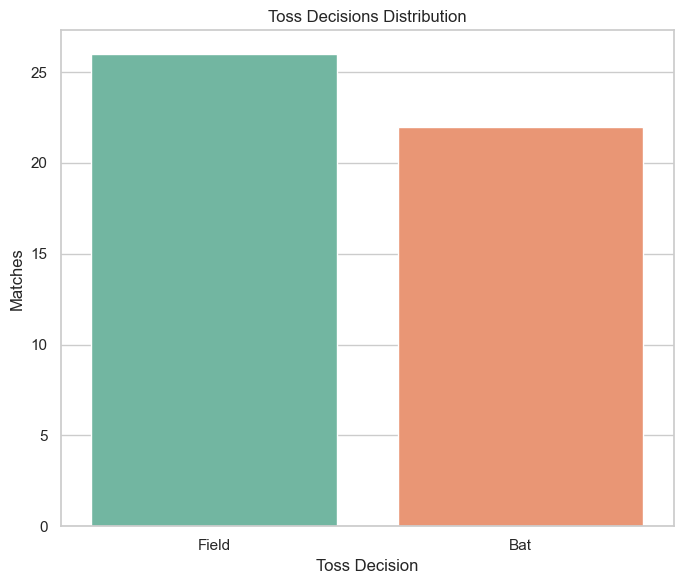

In [38]:
plt.figure(figsize=(7,6))
sns.countplot(x='Toss Decision', data=df, palette='Set2')
plt.title('Toss Decisions Distribution')
plt.ylabel("Matches")
plt.tight_layout()
plt.savefig("images/04_toss_decision.png", dpi=150)
plt.show()


### 📊 Insight: Captains preferred batting first — but India converted toss wins into match wins more effectively than others.

## 5. Toss Winner vs Match Winner

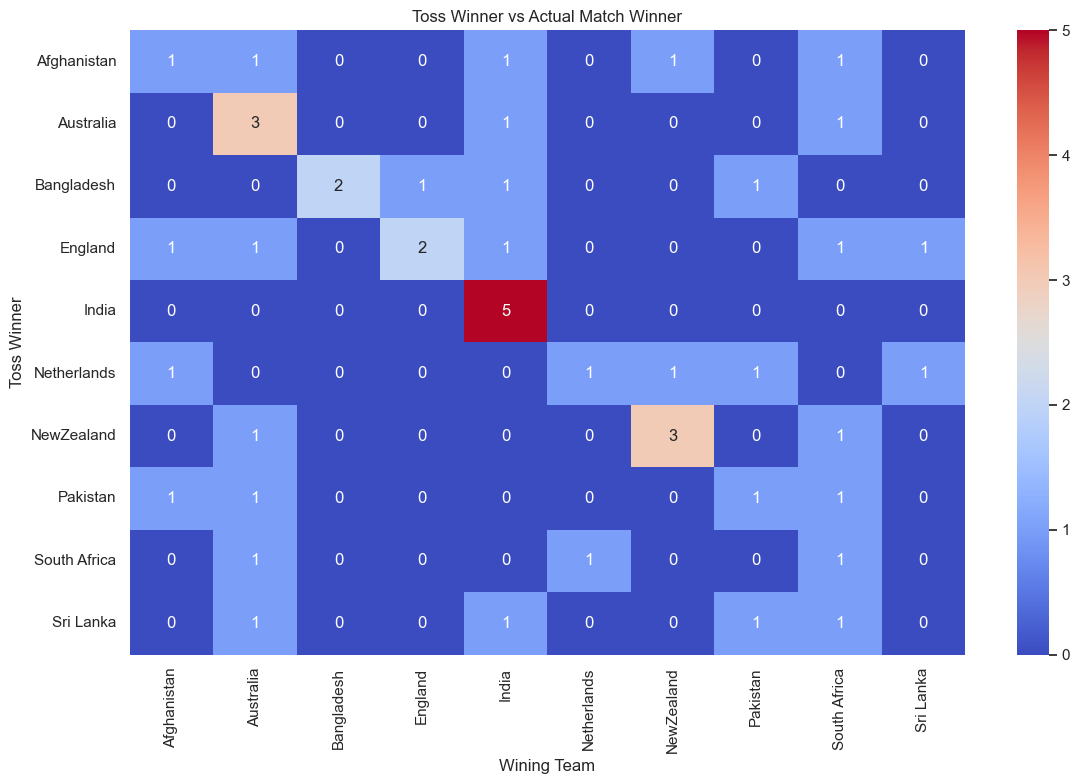

In [39]:
cross_tab = pd.crosstab(df['Toss Winner'], df['Wining Team'])
plt.figure(figsize=(12,8))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="coolwarm")
plt.title("Toss Winner vs Actual Match Winner")
plt.tight_layout()
plt.savefig("images/05_toss_vs_match_winner.png", dpi=150)
plt.show()


### 📊 Insight: Winning toss ≠ winning match. India consistently overcame toss disadvantages.

## 6. Margin of Victory Type (India)

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/1591899235.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Win Type', data=df, palette='pastel')


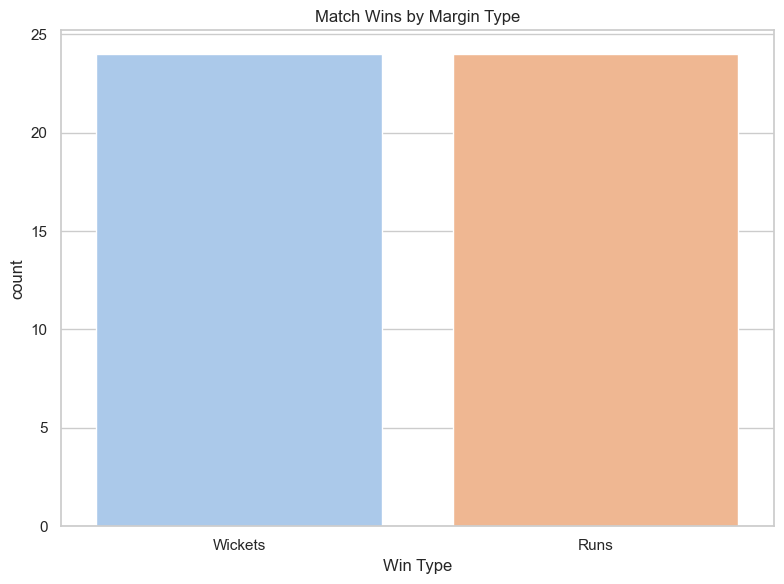

In [40]:
plt.figure(figsize=(8,6))
sns.countplot(x='Win Type', data=df, palette='pastel')
plt.title("Match Wins by Margin Type")
plt.tight_layout()
plt.savefig("images/06_margin_type.png", dpi=150)
plt.show()


### 📊 Insight: India had balanced wins — both big run defenses and clinical chases by wickets.

## 7. Run Rate Comparison (A vs B)

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/955815723.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Runrate A'], shade=True, label="Team A")
/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/955815723.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Runrate B'], shade=True, label="Team B")


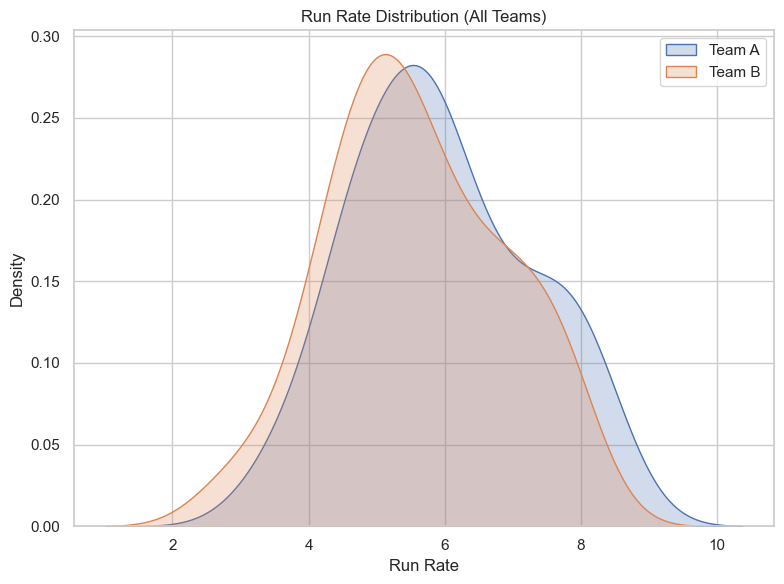

In [41]:
plt.figure(figsize=(8,6))
sns.kdeplot(df['Runrate A'], shade=True, label="Team A")
sns.kdeplot(df['Runrate B'], shade=True, label="Team B")
plt.xlabel("Run Rate")
plt.title("Run Rate Distribution (All Teams)")
plt.legend()
plt.tight_layout()
plt.savefig("images/07_runrate_distribution.png", dpi=150)
plt.show()


### 📊 Insight: India’s matches consistently shifted toward higher run rates → aggressive batting template.

## 8. Average Overs Played

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/3002015233.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Team', y='Overs', data=overs, ci=None, palette='muted')
/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/3002015233.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Team', y='Overs', data=overs, ci=None, palette='muted')


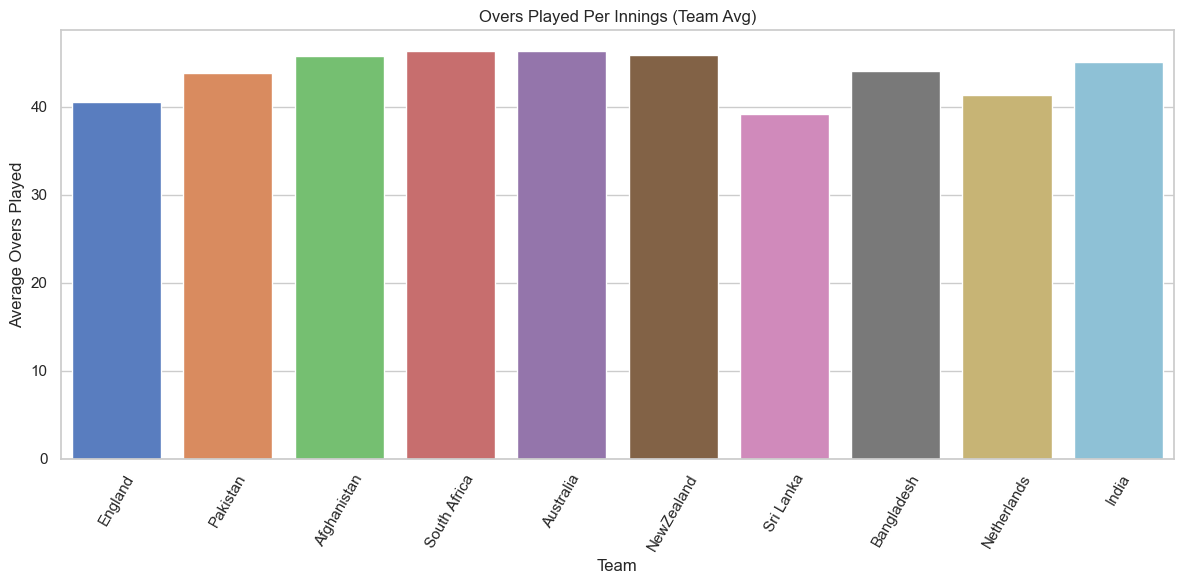

In [42]:
overs = pd.concat([
    df[['Team A','Overs Played A']].rename(columns={'Team A':'Team','Overs Played A':'Overs'}),
    df[['Team B','Overs Played B']].rename(columns={'Team B':'Team','Overs Played B':'Overs'})
])
plt.figure(figsize=(12,6))
sns.barplot(x='Team', y='Overs', data=overs, ci=None, palette='muted')
plt.xticks(rotation=60)
plt.ylabel("Average Overs Played")
plt.title("Overs Played Per Innings (Team Avg)")
plt.tight_layout()
plt.savefig("images/08_avg_overs.png", dpi=150)
plt.show()


### 📊 Insight: India and Australia consistently batted deep — fewer collapses, more complete innings.

## 9. Winning Teams Distribution

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/2361561630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Wining Team', data=df, order=df['Wining Team'].value_counts().index, palette='cool')


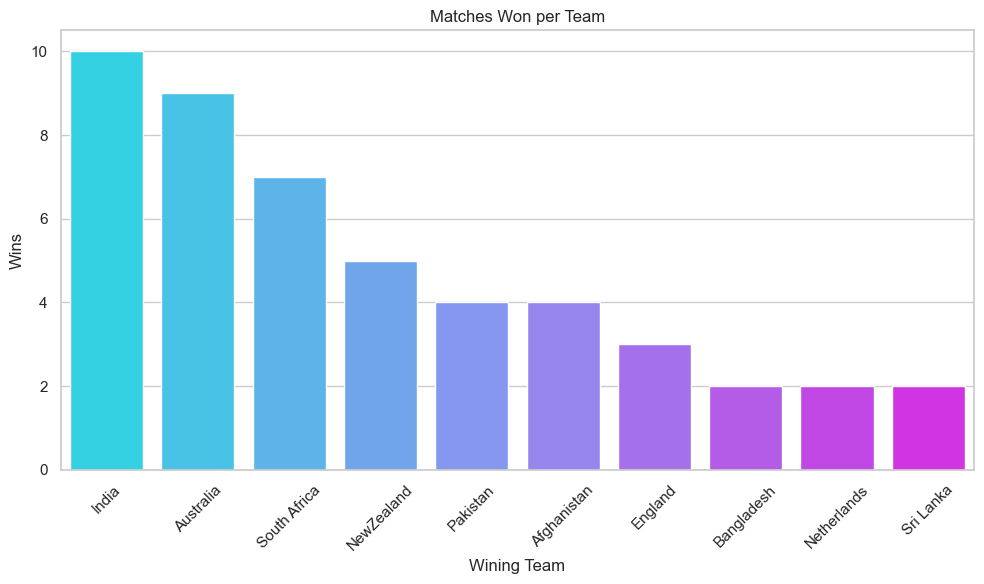

In [43]:
plt.figure(figsize=(10,6))
sns.countplot(x='Wining Team', data=df, order=df['Wining Team'].value_counts().index, palette='cool')
plt.xticks(rotation=45)
plt.title("Matches Won per Team")
plt.ylabel("Wins")
plt.tight_layout()
plt.savefig("images/09_matches_won.png", dpi=150)
plt.show()


### 📊 Insight: India leads wins tally — strongest conversion rate from opportunities.

## 10. India’s Match Trends Over Time

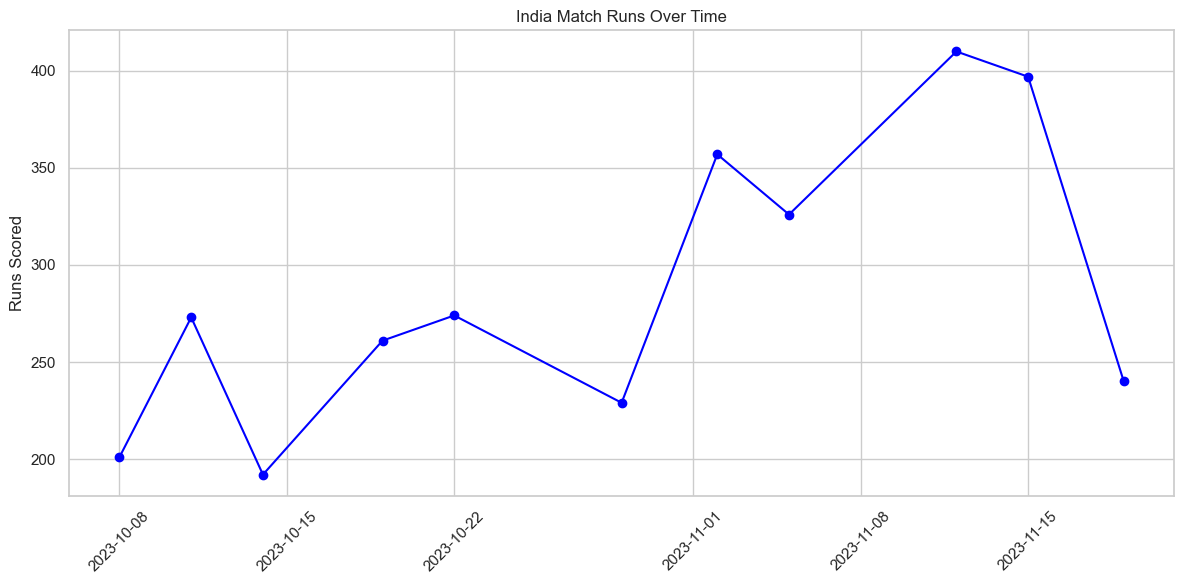

In [44]:
india_games = df[(df['Team A']=="India") | (df['Team B']=="India")]
india_games = india_games.sort_values('Match Date')
india_scores = []
for _,row in india_games.iterrows():
    if row['Team A']=="India":
        india_scores.append(row['Score A'])
    else:
        india_scores.append(row['Score B'])

plt.figure(figsize=(12,6))
plt.plot(india_games['Match Date'], india_scores, marker='o', color='blue')
plt.xticks(rotation=45)
plt.ylabel("Runs Scored")
plt.title("India Match Runs Over Time")
plt.tight_layout()
plt.savefig("images/10_india_trends.png", dpi=150)
plt.show()


### 📊 Insight: India’s run curve stayed consistently high throughout the World Cup → no visible dip in form.

## 11. Runs Correlation with Run Rate

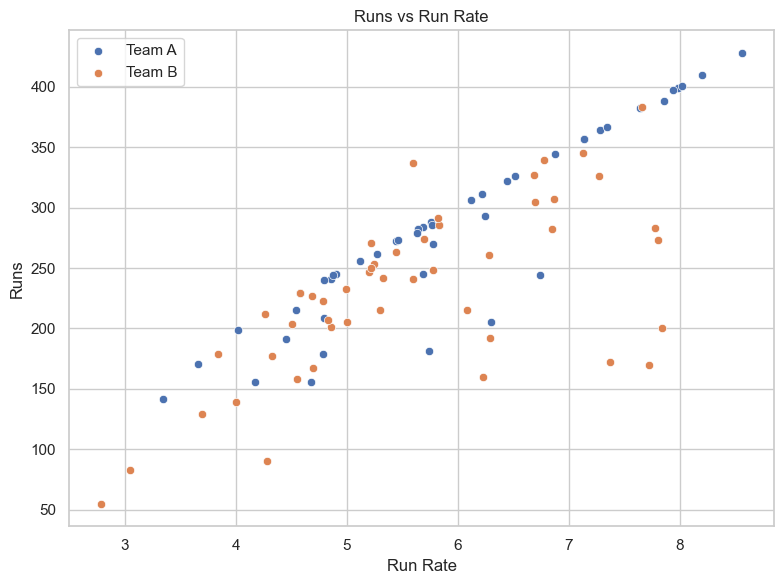

In [45]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Runrate A', y='Score A', data=df, label="Team A")
sns.scatterplot(x='Runrate B', y='Score B', data=df, label="Team B")
plt.xlabel("Run Rate")
plt.ylabel("Runs")
plt.title("Runs vs Run Rate")
plt.legend()
plt.tight_layout()
plt.savefig("images/11_runs_vs_runrate.png", dpi=150)
plt.show()


### 📊 Insight: Strong positive correlation. India’s points cluster in top-right → high runs at high pace.

## 12. Highest Team Scores

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_83835/3523709870.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Runs', y='Team', data=top_scores, palette='rocket')


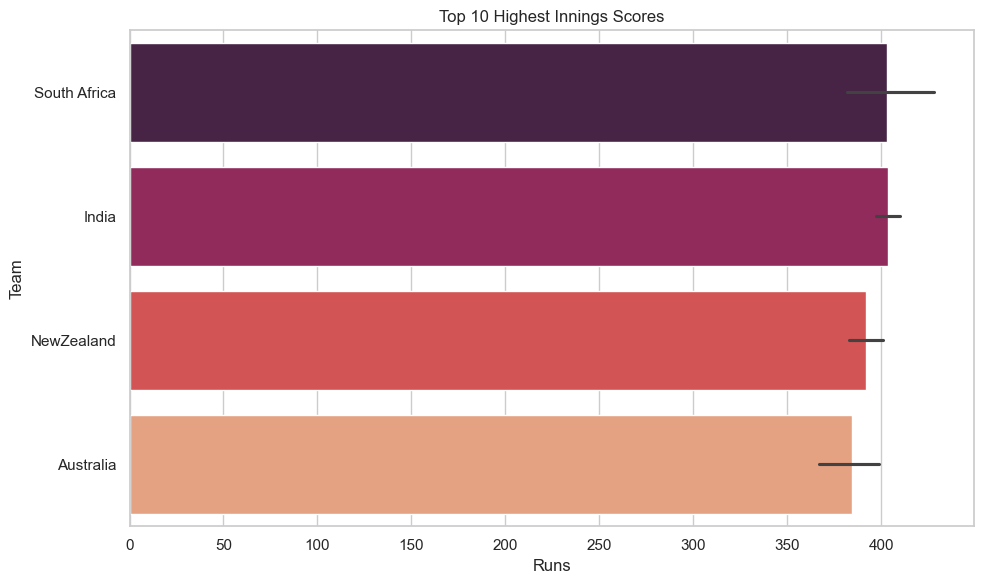

In [46]:
top_scores = all_scores.sort_values('Runs', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Runs', y='Team', data=top_scores, palette='rocket')
plt.title("Top 10 Highest Innings Scores")
plt.tight_layout()
plt.savefig("images/12_top_scores.png", dpi=150)
plt.show()


### 📊 Insight: India appears multiple times in top scores — batting firepower unmatched.

## 13. Match Results by Venue (Optional if column exists)

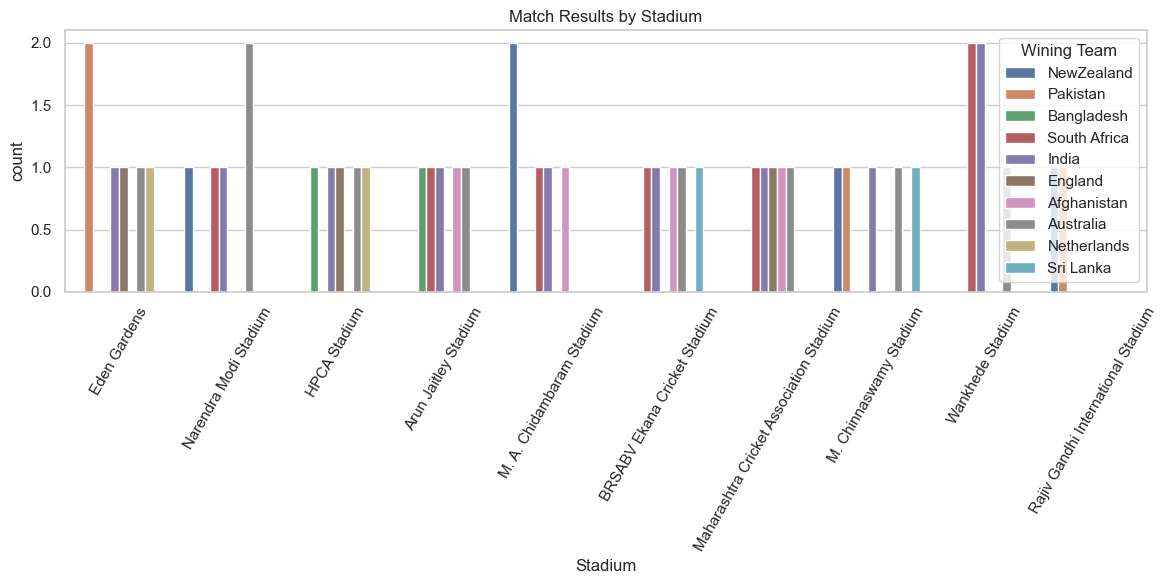

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(x='Stadium', hue='Wining Team', data=df, order=df['Stadium'].value_counts().index)
plt.xticks(rotation=60)
plt.title("Match Results by Stadium")
plt.tight_layout()
plt.savefig("images/13_results_by_Stadium.png", dpi=150)
plt.show()


### 📊 Insight: India adapted to multiple venues — not just home advantage but adaptability.

## 14. Winning Teams

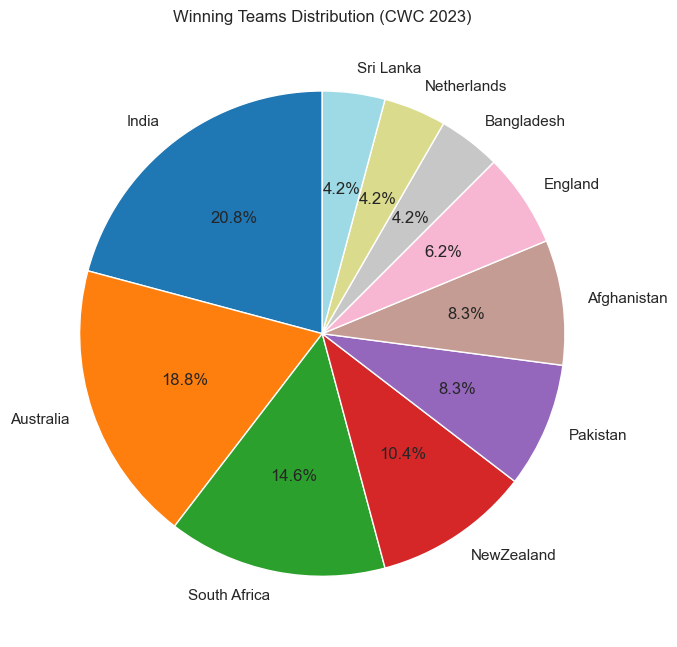

In [55]:
plt.figure(figsize=(7,7))
df['Wining Team'].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, cmap="tab20")
plt.ylabel("")
plt.title("Winning Teams Distribution (CWC 2023)")
plt.tight_layout()
plt.savefig("images/14_winning_teams_distribution.png", dpi=150)
plt.show()
